# 기본

In [49]:
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import font_manager, rc
plt.rcParams['font.family'] = 'NanumGothic'
import platform
if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
    rc('font', family='AppleGothic')

matplotlib.rcParams['axes.unicode_minus'] = False

In [50]:
import os
path = os.path.dirname(os.getcwd())
path = os.path.join(path, "ProcessedData")
train = pd.read_csv(os.path.join(path,"merged_train.csv"))
test = pd.read_csv(os.path.join(path,"merged_test.csv"))

In [51]:
train=train.drop_duplicates(keep='first')
test=test.drop_duplicates(keep='first')

## 1. EDA 및 전처리(baseline: MSE 98)

### 1) 상가비율

In [52]:
tmp = train.groupby(['단지코드','임대건물구분']).count().iloc[:,:1].reset_index()
store = tmp[tmp['임대건물구분']=='상가'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'상가수'})
apt = tmp[tmp['임대건물구분']=='아파트'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'아파트수'})
total = pd.merge(apt,store,on='단지코드',how='left').fillna(0)
total['상가비율'] = total.apply(lambda x : x['상가수']/(x['아파트수']+x['상가수']),axis=1)
train = pd.merge(train,total[['단지코드','상가비율']],on='단지코드',how='left')

In [53]:
tmp = test.groupby(['단지코드','임대건물구분']).count().iloc[:,:1].reset_index()
store = tmp[tmp['임대건물구분']=='상가'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'상가수'})
apt = tmp[tmp['임대건물구분']=='아파트'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'아파트수'})
total = pd.merge(apt,store,on='단지코드',how='left').fillna(0)
total['상가비율'] = total.apply(lambda x : x['상가수']/(x['아파트수']+x['상가수']),axis=1)
test = pd.merge(test,total[['단지코드','상가비율']],on='단지코드',how='left')

### 2) 세대당가능주차면수

In [54]:
train['세대당_가능주차면수'] = train.apply(lambda x : x['단지내주차면수']/x['총세대수'],axis=1)
test['세대당_가능주차면수'] = test.apply(lambda x : x['단지내주차면수']/x['총세대수'],axis=1)

### 3) 공가비율

In [55]:
train['공가비율'] = train.apply(lambda x : x['공가수']/x['총세대수'],axis=1)
test['공가비율'] = test.apply(lambda x : x['공가수']/x['총세대수'],axis=1)

### 4) 대형전용면적

In [56]:
level = 85

In [57]:
train['대형전용면적'] = train['전용면적'].apply(lambda x : 1 if x>level else 0)
test['대형전용면적'] = test['전용면적'].apply(lambda x : 1 if x>level else 0)

### 5) 공급유형
- 공공임대 5년/10년 $\rightarrow$ 공공임대(단기)

In [58]:
train.loc[train.공급유형.isin(['공공임대(5년)', '공공임대(10년)']), '공급유형'] = '공공임대(단기)'
test.loc[test.공급유형.isin(['공공임대(5년)', '공공임대(10년)']), '공급유형'] = '공공임대(단기)'

- 1차원으로 합치기

In [59]:
not_unique = ['공급유형','전용면적','임대건물구분','전용면적별세대수','대형전용면적','임대보증금','임대료','자격유형']

In [60]:
train_one = train.drop(not_unique,axis=1).drop_duplicates().reset_index(drop=True)
test_one = test.drop(not_unique,axis=1).drop_duplicates().reset_index(drop=True)

- 전용면적별세대수 채우기

In [61]:
for i in train['공급유형'].unique():
    train_one[i] = 0
    test_one[i] = 0

In [62]:
sample = pd.DataFrame(train.groupby(['단지코드','공급유형']).sum()['전용면적별세대수']).reset_index()
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'공급유형']
    val = sample.loc[i,'전용면적별세대수']  # 전용면적별세대수
    ind = train_one[train_one['단지코드']==code].index
    train_one.loc[ind,col] = val

In [63]:
sample = pd.DataFrame(test.groupby(['단지코드','공급유형']).sum()['전용면적별세대수']).reset_index()
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'공급유형']
    val = sample.loc[i,'전용면적별세대수']  # 전용면적별세대수
    ind = test_one[test_one['단지코드']==code].index
    test_one.loc[ind,col] = val

### 6) 임대료 임대보증금 : 평균

In [64]:
sample = train.groupby('단지코드').mean()[['임대료','임대보증금']].reset_index()
train_one=pd.merge(train_one, sample, on="단지코드", how="left")

In [65]:
sample = test.groupby('단지코드').mean()[['임대료','임대보증금']].reset_index()
test_one=pd.merge(test_one, sample, on="단지코드", how="left")

### 7) 대형전용면적 총개수

In [66]:
sample = pd.DataFrame(train.groupby('단지코드')['대형전용면적'].sum()).reset_index()
train_one = pd.merge(train_one, sample, on="단지코드", how="left")

In [67]:
sample = pd.DataFrame(test.groupby('단지코드')['대형전용면적'].sum()).reset_index()
test_one = pd.merge(test_one, sample, on="단지코드", how="left")

### 8) 변수제거

In [68]:
col = ['단지명','도로명주소','subway_name','임대상가']

In [69]:
train_one = train_one.drop(col,axis=1)
test_one = test_one.drop(col,axis=1)

## 2. 데이터 나누기: 단지내주차면수 987 기준

In [70]:
train_up = train_one[train_one['단지내주차면수']>=987].reset_index(drop=True)
train_down = train_one[train_one['단지내주차면수']<987].reset_index(drop=True)

In [71]:
test_up = test_one[test_one['단지내주차면수']>=987].reset_index(drop=True)
test_down = test_one[test_one['단지내주차면수']<987].reset_index(drop=True)

### 1) train/test up : area 변수 추가(Baseline추가 MSE:96)

In [72]:
tmp = train[train['단지내주차면수']>=987].reset_index(drop=True)
tmp['등록차량수-총세대수'] = tmp.apply(lambda x : x['등록차량수']-x['총세대수'],axis=1)
tmp['cluster'] = tmp.apply(lambda x : 1 if x['등록차량수-총세대수']>0 else 0 ,axis=1)

<AxesSubplot:xlabel='등록차량수-총세대수', ylabel='Density'>

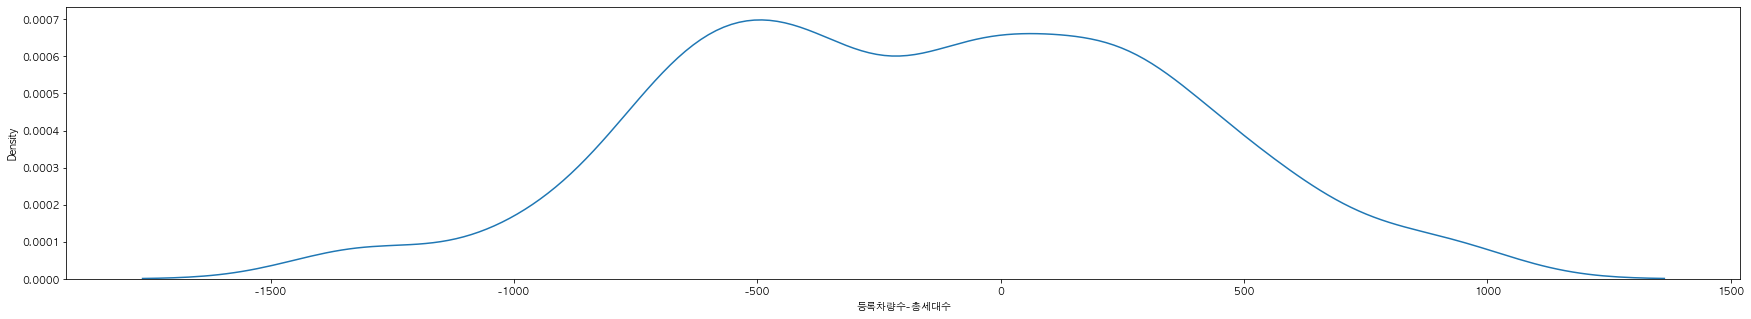

In [73]:
fig, ax = plt.subplots(figsize=(30,5))
sns.kdeplot(data=tmp,x='등록차량수-총세대수')

<AxesSubplot:xlabel='지역', ylabel='count'>

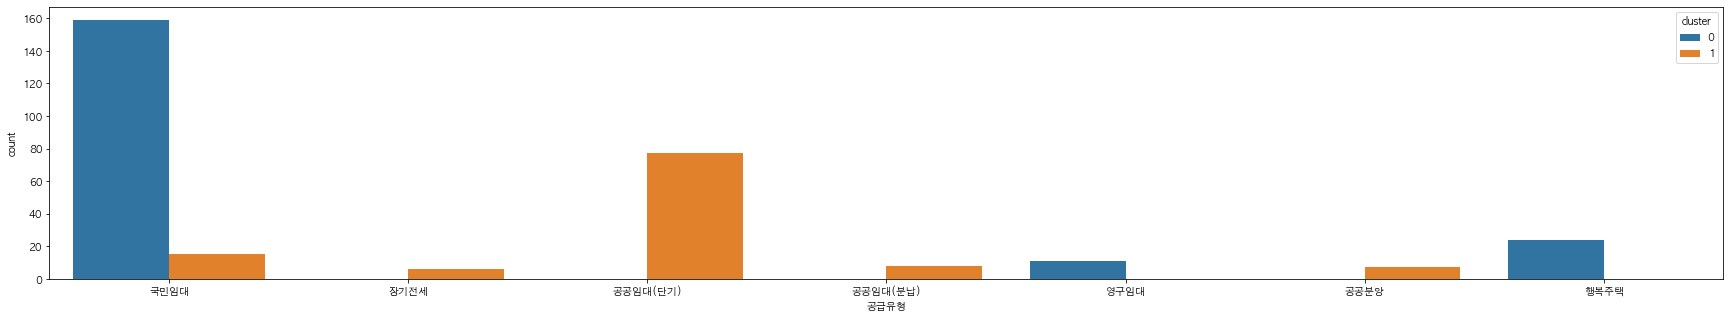

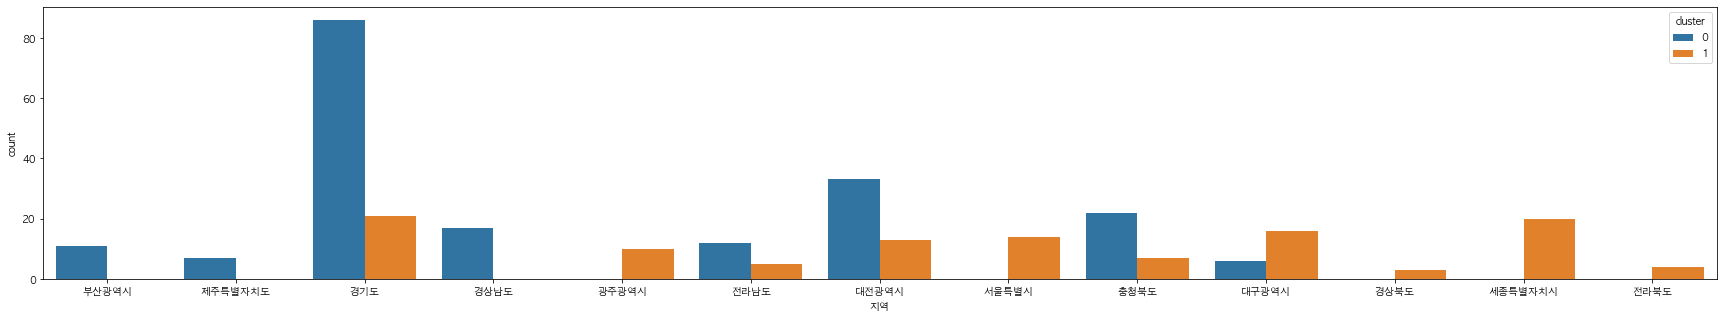

In [74]:
tmp = tmp[(tmp['등록차량수-총세대수']>200)|(tmp['등록차량수-총세대수']<-200)]
fig, ax = plt.subplots(figsize=(30,5))
sns.countplot(data=tmp,x='공급유형',hue='cluster')

fig, ax = plt.subplots(figsize=(30,5))
sns.countplot(data=tmp,x='지역',hue='cluster')

In [75]:
def areafunc(x):
    if x in ['제주특별자치도','경상남도','부산광역시']:
        return 0
    elif x in ['광주광역시','세종특별자치시','경상북도','전라북도','서울특별시']:
        return 1
    elif x in ['대구광역시']:
        return 2
    else: 
        return 3

In [76]:
train_up['지역'] = train_up['지역'].apply(lambda x : areafunc(x))
test_up['지역'] = test_up['지역'].apply(lambda x : areafunc(x))

In [77]:
train_up = train_up.join(pd.get_dummies(train_up['지역'],prefix='area')).iloc[:,:-1]
test_up = test_up.join(pd.get_dummies(test_up['지역'],prefix='area')).iloc[:,:-1]

## 3. 모델링

In [78]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, RepeatedKFold
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor

In [31]:
# def fit(X_train, X_test, y_train, y_test, model):
#     try:
#         model.fit(X_train, y_train, verbose=False)
#     except:
#         model.fit(X_train, y_train)
#     tst_pred = model.predict(X_test)
#     error = mean_absolute_error(y_test,tst_pred)
#     return model, tst_pred, error


# def fit_models(X, y, models, cv=False):
#     X = np.array(X.reset_index(drop=True))
#     y = np.array(y.reset_index(drop=True))
#     best_error = 10000
#     best_tst_pred = 0
#     best_model = ""
#     if cv==False:
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True,random_state=2021)
#         for m in models:
#             model, tst_pred, error = fit(X_train, X_test, y_train, y_test, m)
#             if best_error > error:
#                 best_error = error
#                 best_tst_pred = tst_pred
#                 best_model = model
#     else:
#         best_tst_idx = []
#         kf = KFold(n_splits = 5, shuffle=True,random_state = 2021)
#         for m in models:
#             mae = []
#             pred= []
#             tst_idx = []
#             for train_index, test_index in kf.split(X, y):
#                 X_train, X_test = X[train_index], X[test_index]
#                 y_train, y_test = y[train_index], y[test_index]
#                 model, tst_pred, error = fit(X_train, X_test, y_train, y_test, m)
#                 mae.append(error)
#                 pred.append(tst_pred.tolist())
#                 tst_idx.append(test_index.tolist())
#             cv_error = np.mean(mae)
#             if best_error > cv_error:
#                 best_error = cv_error
#                 best_tst_pred = pred
#                 best_tst_idx = sum(tst_idx, [])
#                 best_model = model
#     best_tst_pred = sum(best_tst_pred,[])
#     best_tst_pred = dict(zip(best_tst_idx,best_tst_pred))
#     try:
#         best_model = best_model.fit(np.concatenate((X_train, X_test),axis=0), 
#                                                 np.concatenate((y_train, y_test),axis=0), 
#                                                 verbose=False)
#     except:
#         best_model = best_model.fit(np.concatenate((X_train, X_test),axis=0), 
#                                         np.concatenate((y_train, y_test),axis=0))
#     return best_model, best_tst_pred, best_error

### 1) train/test down

In [32]:
# X = train_down.drop(columns=['단지코드','등록차량수'],axis=1)
# X = pd.get_dummies(X, drop_first=True) 
# y = train_down['등록차량수']

In [33]:
# models = [CatBoostRegressor(random_state=2021, loss_function = 'MAE')]

# model_down,pred_down,error_down = fit_models(X, y, models, cv=True)
# print('MAE : ',error_down)

MAE :  105.37534703159452


<AxesSubplot:>

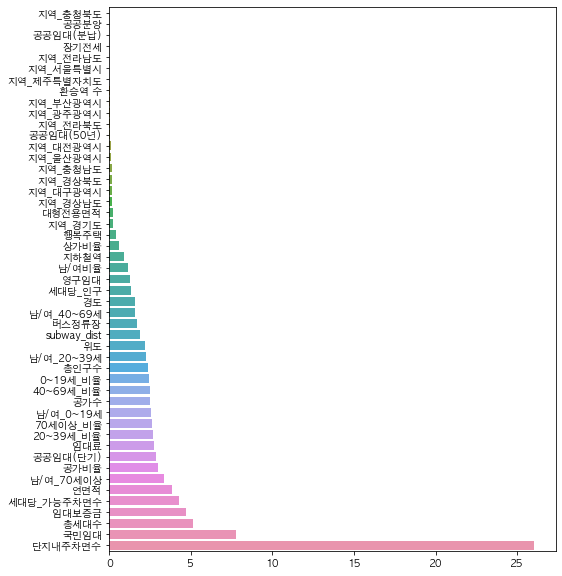

In [34]:
# plt.figure(figsize=(8,10))
# sns.barplot(y = X.columns[np.argsort(model_down.feature_importances_)], x = list(model_down.feature_importances_[np.argsort(model_down.feature_importances_)]))

### 2) train/test up

In [35]:
# X = train_up.drop(columns=['단지코드','등록차량수','지역','상가비율'],axis=1)
# X = X[['총세대수', '공가수', '지하철역', '버스정류장', '단지내주차면수', '연면적', '위도', '경도',
#        'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세',
#        '남/여_20~39세', '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
#        '40~69세_비율', '70세이상_비율', '세대당_가능주차면수', '공가비율', '국민임대', '영구임대',
#        '공공임대(단기)', '장기전세', '행복주택', '공공임대(분납)', '공공분양', '공공임대(50년)', '임대료',
#        '임대보증금', '대형전용면적', 'area_0', 'area_1', 'area_2']]
# y = train_up['등록차량수']

# models = [CatBoostRegressor(random_state=2021, loss_function = 'MAE')]

# model_up,pred_up,error_up = fit_models(X, y, models, cv=True)
# print('MAE : ',error_up)

MAE :  295.9342977834218


<AxesSubplot:>

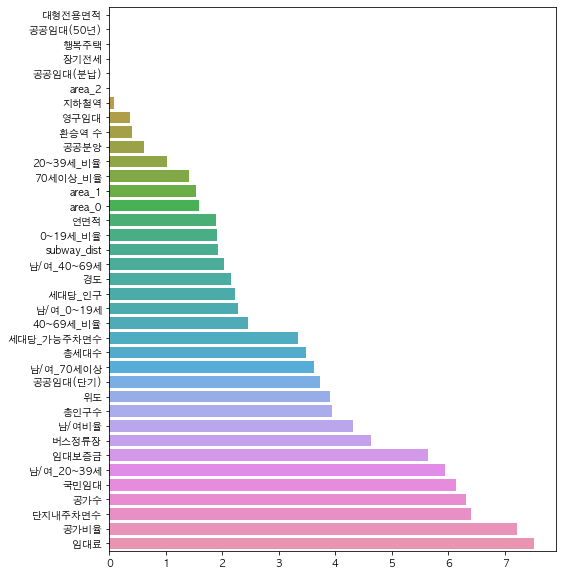

In [36]:
# plt.figure(figsize=(8,10))
# sns.barplot(y = X.columns[np.argsort(model_up.feature_importances_)], x = list(model_up.feature_importances_[np.argsort(model_up.feature_importances_)]))

## 4. Final prediction

In [79]:
col = ['총세대수', '공가수', '지하철역', '버스정류장', '단지내주차면수', '연면적', '위도', '경도',
       'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세',
       '남/여_20~39세', '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '상가비율', '세대당_가능주차면수', '공가비율', '국민임대', '영구임대',
       '공공임대(단기)', '장기전세', '행복주택', '공공임대(분납)', '공공분양', '공공임대(50년)', '임대료',
       '임대보증금', '대형전용면적', '지역_경기도', '지역_경상남도', '지역_경상북도', '지역_광주광역시',
       '지역_대구광역시', '지역_대전광역시', '지역_부산광역시', '지역_서울특별시', '지역_세종특별자치시',
       '지역_울산광역시', '지역_전라남도', '지역_전라북도', '지역_제주특별자치도', '지역_충청남도', '지역_충청북도']

In [80]:
X_train = train_down.drop(columns=['단지코드','등록차량수'],axis=1)
X_train = pd.get_dummies(X_train, drop_first=True) 
X_train['지역_세종특별자치시'] = 0
X_train = X_train[col]
y_train = train_down['등록차량수']
X_test = test_down.drop(columns=['단지코드'],axis=1)
X_test = pd.get_dummies(X_test, drop_first=True) 
X_test['지역_서울특별시'] = 0
X_test = X_test[col]

In [81]:
cb_down = CatBoostRegressor(random_state=2021,verbose=False).fit(X_train,y_train)
pred_down = cb_down.predict(X_test)

In [82]:
col = ['총세대수', '공가수', '지하철역', '버스정류장', '단지내주차면수', '연면적', '위도', '경도',
       'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세',
       '남/여_20~39세', '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '세대당_가능주차면수', '공가비율', '국민임대', '영구임대',
       '공공임대(단기)', '장기전세', '행복주택', '공공임대(분납)', '공공분양', '공공임대(50년)', '임대료',
       '임대보증금', '대형전용면적', 'area_0', 'area_1', 'area_2']

In [83]:
X_train = train_up.drop(columns=['단지코드','등록차량수','지역'],axis=1)
X_train = X_train[col]
y_train = train_up['등록차량수']
X_test = test_up.drop(columns=['단지코드','지역'],axis=1)
X_test = X_test[col]

cb_up = CatBoostRegressor(random_state=2021,verbose=False,loss_function='MAE').fit(X_train,y_train)
pred_up1 = cb_up.predict(X_test)

In [84]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso

X_train = train_up.drop(columns=['단지코드','등록차량수','지역'],axis=1)
X_train = X_train[col]
y_train = train_up['등록차량수']
X_test = test_up.drop(columns=['단지코드','지역'],axis=1)
X_test = X_test[col]
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

ls_up = Lasso(random_state=2021).fit(X_train,y_train)
pred_up2 = ls_up.predict(X_test)

In [89]:
pred_up1

array([1188.38263433, 1327.91922633, 1797.68783597, 1048.37204008,
        847.31618277, 1440.36636903, 1193.93685055, 1067.29611196,
       1205.94095428, 1060.46984849, 1119.03505356, 1178.80059893,
       1023.26286876, 1191.69822174, 1139.37937563,  940.64133914,
        969.00495952,  899.031182  , 1287.07197144])

In [88]:
pred_up2

array([1077.48679226, 1148.00739692, 1900.68216084, 1114.22455344,
        623.93824612, 1685.9708948 , 1045.50898881,  657.42137848,
       1036.19698988, 1287.16193065,  884.26812607, 1437.86624395,
       1241.68044049, 1255.14004812,  876.23979581, 1162.81359369,
        -18.06002316,  417.65568264, 1222.745213  ])

In [134]:
pred_up = (pred_up1*5+pred_up2)/6
pred_up

array([1169.89999399, 1297.93392143, 1814.85355678, 1059.34745898,
        810.08652666, 1481.30045666, 1169.19887359,  998.98365638,
       1177.65029355, 1098.25186218, 1079.90723231, 1221.97820643,
       1059.66579738, 1202.27185947, 1095.52277899,  977.67004823,
        804.49412908,  818.80193211, 1276.35084503])

In [135]:
pred_up[pred_up2<0] = pred_up1[pred_up2<0]

In [116]:
pred_up

array([1151.41735364, 1267.94861653, 1832.01927759, 1070.32287787,
        772.85687055, 1522.23454429, 1144.46089664,  930.6712008 ,
       1149.35963282, 1136.03387588, 1040.77941106, 1265.15581394,
       1096.068726  , 1212.8454972 , 1051.66618236, 1014.69875732,
        969.00495952,  738.57268221, 1265.62971862])

In [123]:
def get_pred():
    res_down = pd.DataFrame()
    res_down['code'] = test_down['단지코드'].values
    res_down['num'] = pred_down
    res_up = pd.DataFrame()
    res_up['code'] = test_up['단지코드'].values
    res_up['num'] = pred_up 
    res = pd.concat([res_down,res_up],axis=0).reset_index(drop=True)
    return res_down, res_up, res

## 5. 기존 score와 비교 및 제출

In [136]:
def submit():
    res = get_pred()[2]
    res.loc[147,:] = ['C1327',0]
    res.loc[148,:] = ['C2335',0]
    res.loc[149,:] = ['C2675',0]
    return res

In [137]:
sub = submit()
#sub.to_csv("result/0723_4:1.csv",index=False)

In [133]:
get_pred()[2]

,code,num
0,C1072,751.540951
1,C1456,539.409116
2,C1840,533.220234
3,C1640,464.134797
4,C1377,364.187487
...,...,...
142,C1525,1086.751460
143,C2267,985.075790
144,C1692,969.004960
145,C1570,802.756082


In [109]:
def score(mse):
    score = pd.read_csv("Users/seungji/Desktop/Dacon/Daesamanlap/Final/result/MAE_"+str(mse)+".csv")
    score = pd.merge(score,get_pred()[2],on='code',how='inner')
    val = test_up['단지코드'].values
    score_up = score.loc[score['code'].isin(val),:]
    score_down = score.loc[-score['code'].isin(val),:] #y가 새롭게 예측
    mae = mean_absolute_error(score['num_x'],score['num_y'])
    mae_up = mean_absolute_error(score_up['num_x'],score_up['num_y'])
    mae_down = mean_absolute_error(score_down['num_x'],score_down['num_y'])
    print('전체 MAE : ',mae)
    print('큰 영역 MAE : ',mae_up)
    print('작은 영역 MAE : ',mae_down)
    return score

In [111]:
def score(mse):
    score = pd.read_csv("/Users/seungji/Downloads/MAE_"+str(mse)+".csv")
    score = pd.merge(score,get_pred()[2],on='code',how='inner')
    val = test_up['단지코드'].values
    score_up = score.loc[score['code'].isin(val),:]
    score_down = score.loc[-score['code'].isin(val),:] #y가 새롭게 예측
    mae = mean_absolute_error(score['num_x'],score['num_y'])
    mae_up = mean_absolute_error(score_up['num_x'],score_up['num_y'])
    mae_down = mean_absolute_error(score_down['num_x'],score_down['num_y'])
    print('전체 MAE : ',mae)
    print('큰 영역 MAE : ',mae_up)
    print('작은 영역 MAE : ',mae_down)
    return score

In [112]:
# 1:1
res2 = score(96)

전체 MAE :  12.55129822011745
큰 영역 MAE :  97.10741254511896
작은 영역 MAE :  3.68594044175552e-14


In [120]:
# 2:1
res2 = score(96)

전체 MAE :  8.367532146744978
큰 영역 MAE :  64.73827503007932
작은 영역 MAE :  3.68594044175552e-14


In [126]:
# 3:1
res2 = score(96)

전체 MAE :  6.275649110058746
큰 영역 MAE :  48.553706272559516
작은 영역 MAE :  3.68594044175552e-14


In [131]:
# 4:1
res2 = score(96)

전체 MAE :  5.020519288047
큰 영역 MAE :  38.84296501804759
작은 영역 MAE :  3.68594044175552e-14


In [138]:
# 5:1
res2 = score(96)

전체 MAE :  4.183766073372504
큰 영역 MAE :  32.369137515039654
작은 영역 MAE :  3.68594044175552e-14


In [47]:
res1 = score(98)

전체 MAE :  7.482271233341923
큰 영역 MAE :  57.88915112111887
작은 영역 MAE :  3.0753177782116836e-14
